# Análisis mercado inmobiliario de la Ciudad de Buenos Aires

En este proyecto voy a trabajar con un dataset de propiedades en venta publicadas en el portal [Properati](www.properati.com.ar). El objetivo es dar los primeros pasos en el proceso de exploración de datos.

Voy a enfocarme en analizar algunos aspectos del mercado inmobiliario de la Ciudad de Buenos Aires, pero para eso primero hay que limpiar un poco el dataset.

## El dataset: propiedades en venta en Ciudad de Buenos Aires.

## Importando las bibliotecas necesarias

Para poder trabajar en la limpieza de datos y la visualización del dataset voy a utilizar las bibliotecas numpy, pandas, matplotlib.pylab y seaborn.

In [1]:
# Importo las librerías que voy a utilizar
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

In [2]:
# La siguiente línea es para ver las imagenes dentro del notebook
%matplotlib inline

# Configuro el tamaño de las figuras
plt.rcParams['figure.figsize'] = (12,8)

# Seteo opciones de pandas sobre las columnas y su ancho
pd.set_option('max_columns', 120)
pd.set_option('max_colwidth', 5000)

## Cargando dataset de propiedades

Cargo el dataset que se encuentra en la carpeta *dataset/* y lo guardo en una variable llamada **df**. 
Sobre la columna **created_on** utilizo **parse_dates**.


In [3]:
# Cargo el dataset en ésta celda
path_dataset = 'dataset/datos_properati.csv'
df = pd.read_csv(path_dataset, parse_dates=['created_on'])

## Exploración de datos

Lo primero que voy a hacer es ver qué forma tiene el dataset que acabo de cargar. Para eso voy a mostrar las primeras 3 entradas del mismo y utilizar la propiedad `shape` para ver la cantidad de instancias y atributos con los que voy a estar trabajando.

In [4]:
print(df.shape)
df.head(3)

(18979, 17)


,created_on,operation,property_type,place_with_parent_names,lat-lon,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,properati_url,barrio,comuna
0,2017-09-22,sell,house,|Argentina|Capital Federal|Palermo|Palermo Viejo|,"-34.5889531469,-58.4298817776",-34.588953,-58.429882,2000000.0,312.0,NaN,6410.25641,NaN,NaN,NaN,https://www.properati.com.ar/2os_venta_casa_palermo-viejo_rent-ba,PALERMO,14.0
1,2017-08-01,sell,store,|Argentina|Capital Federal|Palermo|,"-34.586069,-58.414431",-34.586069,-58.414431,790000.0,121.0,121.0,6528.92562,NaN,NaN,NaN,https://www.properati.com.ar/1cl7l_venta_local_palermo_santa-fe-av-al-3500_sotano_garage_subte-linea-d_deptos-temporarios,PALERMO,14.0
2,2017-08-02,sell,store,|Argentina|Capital Federal|Palermo|Palermo Soho|,"-34.589723,-58.4325664",-34.589723,-58.432566,343000.0,122.0,108.0,2811.47541,NaN,2.0,NaN,https://www.properati.com.ar/1cm8w_venta_local_palermo-soho_cabrera-jose-a-_5000_jardin_lavadero_patio_piscina_toilette_garage_ojo-propiedades,PALERMO,14.0


## Categorías de propiedades
En primer lugar voy a ver qué categorías existen en el campo `property_type`. Y de esas categorías cuántos valores tenemos de cada uno.

In [5]:
print(df['property_type'].unique())
print(df['property_type'].value_counts())

['house' 'store' 'apartment' 'PH']
apartment    14807
house         1618
PH            1463
store         1091
Name: property_type, dtype: int64


### Filtrando las categorías

De las categorías existentes sólo me voy a quedar con las que sean casas (house), departamentos (apartment) o PH (PH). 

Para ésto voy a **filtrar** el `dataframe` original creando un **nuevo** `dataframe` llamado `df_filtered`. Éste es el `dataframe` que seguiré usando a lo largo del análisis.

In [6]:
df_filtered = df[df.property_type.isin(['house', 'apartment', 'PH'])]

### Visualizando las categorías
Utilizando `seaborn` voy a **crear un countplot** para visualizar las categorías de `df_filtered` en el campo `property_type`.

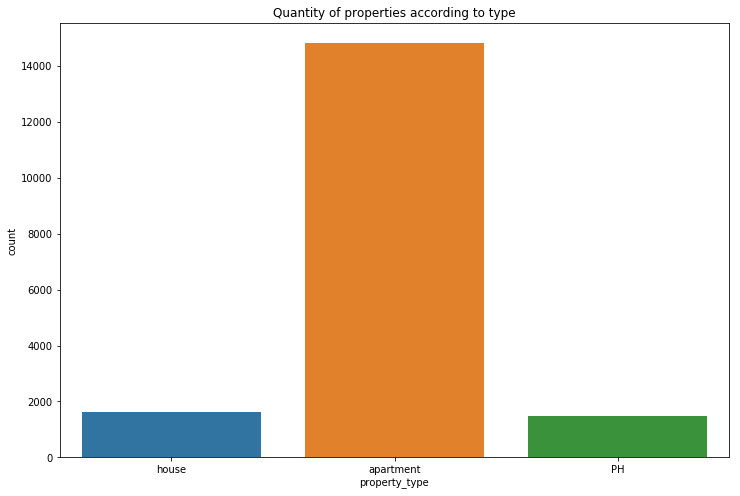

In [7]:
ax = sns.countplot(x="property_type", data=df_filtered).set_title('Quantity of properties according to type')

## Valores Faltantes

Voy a querer descartar aquellas instancias que tengan valores nulos en columnas importantes para el análisis del mercado.
Éstas columnas son las que informan **superficie (total o cubierta)**, **cantidad de ambientes**, **precio** y **precio por metro cuadrado**.

**Quito** del `dataframe` las instancias que no tengan ningún valor en los campos nombrados.

In [8]:
surface = df_filtered.surface_covered_in_m2.notnull() | df_filtered.surface_total_in_m2.notnull() 
rooms = df_filtered.rooms.notnull()
price = df_filtered.price_aprox_usd.notnull()
price_m2 = df_filtered.price_usd_per_m2.notnull()

df_filtered = df_filtered[surface & rooms & price & price_m2]

A continuación **muestro** cuántas instancias son las que descarté a partir de quitar las que tenían valores nulos.

In [9]:
n_original_rows = df.shape[0]
n_non_filtered_rows = df_filtered.shape[0]
n_filtered_rows = n_original_rows - n_non_filtered_rows
print('{} instancias fueron descartadas por contener valores nulos'.format(n_filtered_rows))

6649 instancias fueron descartadas por contener valores nulos


Posiblemente existan otros atributos con valores faltantes en el dataset, pero que no son de tanta importancia. 

**Mostremos** qué otros atributos tienen valores faltantes en el `dataframe`.

In [10]:
df_filtered_nulls = df_filtered.isnull()
columns_nulls = df_filtered.columns[df_filtered_nulls.any()].tolist()
print(columns_nulls)

['surface_covered_in_m2', 'floor', 'expenses']


#### Se podrá plantear alguna estrategia para reemplazar los valores faltantes en el atributo `surface_total_in_m2`?

Una manera de reemplazar los valores faltantes de `surface_total_in_m2` podría ser buscar la tendencia central de los valores de `surface_total_in_m2` a partir de cada tipo de propiedad, lo cual daría una idea del valor "típico" de ese conjunto de datos para reemplazar por los valores faltantes. Si bien la media y la mediana son medidas de tendencia central, la media tiene la desventaja de ser influida por valores separados que son mucho más altos o mucho más bajos que el resto de los valores. La mediana en cambio, es una métrica de punto medio mejor para los casos en los que un número pequeño de valores atípicos podrían sesgar drásticamente la media.

Para detectar la existencia de valores que puedan sesgar la media una buena opción es visualizar los datos haciendo un boxplot.

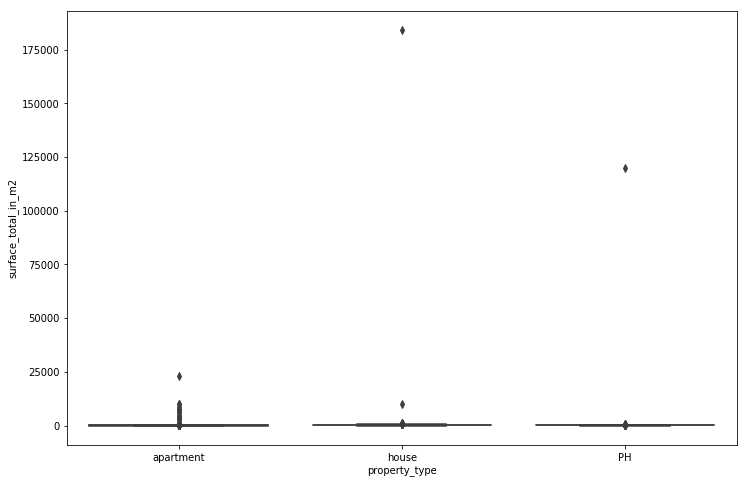

In [11]:
ax = sns.boxplot(x="property_type", y="surface_total_in_m2",  data=df_filtered)

Como se observan valores atípicos voy a usar la mediana para completar los valores faltantes. Primero calculo la mediana de cada categoría de `property_type`.

In [12]:
median_property_type = df_filtered.groupby(['property_type'])['surface_total_in_m2'].median().reset_index()
median_property_type

,property_type,surface_total_in_m2
0,PH,117.5
1,apartment,69.0
2,house,235.0


In [13]:
df_filtered[df_filtered.property_type == "PH"].fillna(median_property_type.loc[0, 'surface_total_in_m2'])
df_filtered[df_filtered.property_type == "apartment"].fillna(median_property_type.loc[1, 'surface_total_in_m2'])
df_filtered[df_filtered.property_type == "house"].fillna(median_property_type.loc[2, 'surface_total_in_m2'])

,created_on,operation,property_type,place_with_parent_names,lat-lon,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,properati_url,barrio,comuna
22,2017-08-30,sell,house,|Argentina|Capital Federal|Palermo|Palermo Hollywood|,"-34.5793535,-58.4364489",-34.579354,-58.436449,1200000.0,532.0,334.0,2255.639098,235.0,6.0,235.0,https://www.properati.com.ar/1e1ve_venta_casa_palermo-hollywood_jardin_lavadero_piscina_luminoso_vista_garage_nexo-propiedades_h0z,PALERMO,14.0
34,2017-08-31,sell,house,|Argentina|Capital Federal|Palermo|Palermo Chico|,"-34.5780733419,-58.4055800042",-34.578073,-58.405580,1975000.0,460.0,400.0,4293.478261,235.0,6.0,235.0,https://www.properati.com.ar/1e403_venta_casa_palermo-chico_castex_3200_suite_jardin_dependencias_electrogeno_garage_impecable_aire-acondicionado_arana-parera-propiedades_h3y,PALERMO,14.0
41,2017-09-01,sell,house,|Argentina|Capital Federal|Palermo|Palermo Chico|,"-34.5782697,-58.3993206",-34.578270,-58.399321,1750000.0,300.0,235.0,5833.333333,235.0,5.0,235.0,https://www.properati.com.ar/1e6c0_venta_casa_palermo-chico_balcon_jardin_lavadero_patio_piscina_quincho_terraza_toilette_vista_dependencias_garage_doble-circulacion_monica-frettes,PALERMO,14.0
58,2017-09-04,sell,house,|Argentina|Capital Federal|Palermo|,"-34.567097,-58.436086",-34.567097,-58.436086,594900.0,208.0,190.0,2860.096154,235.0,6.0,235.0,https://www.properati.com.ar/1eado_venta_casa_palermo_balcon_baulera_suite_lavadero_terraza_luminoso_placard_re-max-liberty-ii,PALERMO,14.0
106,2017-09-07,sell,house,|Argentina|Capital Federal|Belgrano|,"-34.566867,-58.444197",-34.566867,-58.444197,1650000.0,455.0,456.0,3626.373626,235.0,5.0,235.0,https://www.properati.com.ar/1ehbq_venta_casa_belgrano_suite_gimnasio_hidromasaje_jardin_lavadero_parrilla_patio_quincho_terraza_toilette_vestidor_luminoso_lujoso_garage_impecable_subte-linea-d_re-max-win,PALERMO,14.0
145,2017-09-10,sell,house,|Argentina|Capital Federal|Palermo|,"-34.5887219,-58.4244814",-34.588722,-58.424481,610000.0,150.0,118.0,4066.666667,235.0,4.0,235.0,https://www.properati.com.ar/1elf3_venta_casa_palermo_nicaragua-al-4500_lavadero_parrilla_patio_quincho_terraza_toilette_dependencias_deptos-temporarios,PALERMO,14.0
198,2017-09-13,sell,house,|Argentina|Capital Federal|Palermo|Palermo Chico|,"-34.5774344,-58.4014371",-34.577434,-58.401437,2900000.0,580.0,380.0,5000.000000,235.0,6.0,235.0,https://www.properati.com.ar/1eqz8_venta_casa_palermo-chico_suite_hidromasaje_parrilla_patio_piscina_terraza_toilette_vestidor_luminoso_dependencias_garage_aire-acondicionado_wyp-propiedades,PALERMO,14.0
211,2017-09-15,sell,house,|Argentina|Capital Federal|Palermo|,"-34.5707717,-58.431808",-34.570772,-58.431808,1700000.0,754.0,754.0,2254.641910,235.0,8.0,235.0,https://www.properati.com.ar/1et3r_venta_casa_palermo_chenaut-indalesio-gral-av-_1800_suite_jardin_piscina_quincho_luminoso_garage_subte-linea-d_federico-galceran-propiedades,PALERMO,14.0
391,2017-09-30,sell,house,|Argentina|Capital Federal|Palermo|,"-34.5729498083,-58.4316390753",-34.572950,-58.431639,940000.0,450.0,375.0,2088.888889,235.0,10.0,235.0,https://www.properati.com.ar/1flw2_venta_casa_palermo_huergo_200_suite_hidromasaje_patio_quincho_terraza_lujoso_amoblado_subte-linea-d_massana-propiedades_h6q,PALERMO,14.0
413,2017-10-02,sell,house,|Argentina|Capital Federal|Palermo|,"-34.579839,-58.433869",-34.579839,-58.433869,320000.0,100.0,60.0,3200.000000,3.0,3.0,235.0,https://www.properati.com.ar/1fp1a_venta_casa_palermo_soler_5700_balcon_lavadero_parrilla_terraza_toilette_vestidor_subte-linea-d_re-max-premium,PALERMO,14.0


## Datos erróneos

El siguiente paso es analizar errores que puede llegar a haber en el dataset. 

Por ejemplo, la **superficie total no puede ser menor que la cubierta**. Si esto sucede, podemos optar por eliminar esas filas o intentar corregir el problema. Veamos en primer lugar si ésto sucede.

Primero voy a mostrar cuántas instancias existen que tengan el problema de éste dato erróneo y las voy a guardar en una variable llamada `wrong_surface_rows`.

In [14]:
wrong_surface_rows = df_filtered[df_filtered.surface_total_in_m2 < df_filtered.surface_covered_in_m2]
print('Existen {} instancias con el dato de superficie erróneo.'.format(wrong_surface_rows.shape[0]))

Existen 73 instancias con el dato de superficie erróneo.


Propongo no borrar éstas instancias erróneas, sino intercambiar los valores de **superficie total** con **superficie cubierta** en caso de que se cumpla la condición mencionada.

In [15]:
df_filtered.at[wrong_surface_rows.index, 'surface_total_in_m2'] = wrong_surface_rows.surface_covered_in_m2
df_filtered.at[wrong_surface_rows.index, 'surface_covered_in_m2'] = wrong_surface_rows.surface_total_in_m2

Por otro lado, sucede que las inmobiliarias cuando no cuentan con las coordenadas reales de las propiedades utilizan valores que no son correctos. Por ejemplo, el punto centro de cada barrio o puntos de interés como el Obelisco. Ésto puede afectar el análisis relacionado con la ubicación de cada propiedad.

Veamos en primer lugar si hay coordenadas que se repiten.

In [16]:
conteo_puntos = df_filtered.groupby(['lat', 'lon']).size()
conteo_puntos[conteo_puntos > 1].sort_values(ascending=False).head(10)

lat         lon       
-34.589546  -58.397364    149
-34.571150  -58.423297    118
-34.562084  -58.456686     77
-34.620928  -58.445874     45
-34.609821  -58.392606     36
-34.610122  -58.405941     31
-34.597679  -58.443019     31
-34.621184  -58.373116     31
-34.617719  -58.362056     31
-34.598647  -58.439018     29
dtype: int64

Por ejemplo, para el caso del tercer punto, se puede verificar que corresponde a la esquina de Av. Cabildo y Juramento.
Nos quedamos entonces con las propiedades con coordenadas que se repitan hasta 5 veces.

In [17]:
conteo_puntos.name = 'conteo'

df_filtered = df_filtered.join(conteo_puntos, on=['lat', 'lon'])

df_filtered = df_filtered[df_filtered.conteo <= 5]

Eliminamos el atributo `conteo` dado que ya no nos sirve.

In [18]:
df_filtered.drop('conteo', inplace=True, axis=1)

## Estudiando los barrios

### Barrios con más edificios y barrios con más casas
Al saber qué barrios son los que tienen más cantidad de edificios en venta y cuáles son los que tienen más casas podemos darnos una idea de qué tipo de barrio es. Si es más residencial, con más población, poder adquisitivo, etc. 
Para eso voy a empezar calculando los porcentajes de cada tipo de propiedad según el barrio.

In [19]:
total_propiedades = df_filtered.groupby('barrio')['property_type'].count().values

In [20]:
porcentaje_casas_ph = df_filtered[df_filtered.property_type.isin(['PH', 'house'])].groupby('barrio').count().property_type/total_propiedades
porcentaje_edificios = df_filtered[df_filtered.property_type == 'apartment'].groupby('barrio').count().property_type/total_propiedades

In [21]:
print("Barrios con mayor porcentaje de edificios: \n", porcentaje_edificios.sort_values()[::-1][:5])
print("Barrios con mayor porcentaje de casas y phs: \n ", porcentaje_casas_ph.sort_values()[::-1][:5])

Barrios con mayor porcentaje de edificios: 
 barrio
PUERTO MADERO    0.995413
RETIRO           0.992736
SAN NICOLAS      0.989691
RECOLETA         0.986654
BELGRANO         0.951760
Name: property_type, dtype: float64
Barrios con mayor porcentaje de casas y phs: 
  barrio
VERSALLES            0.608696
MATADEROS            0.604651
VILLA RIACHUELO      0.555556
PARQUE AVELLANEDA    0.544118
VILLA REAL           0.500000
Name: property_type, dtype: float64


Para darnos una idea de las diferencias entre los porcentajes de edificios y casas en éstos barrios, voy a graficarlos
en forma de torta.

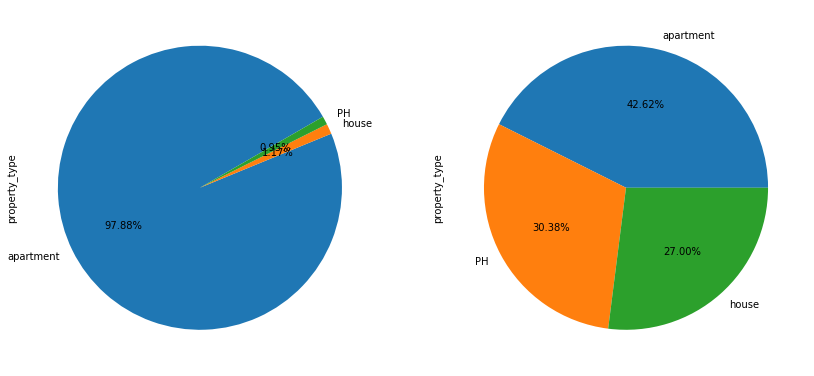

In [22]:
barrios_casas = porcentaje_casas_ph.sort_values()[::-1][:5].index
barrios_edificios = porcentaje_edificios.sort_values()[::-1][:5].index
fig, axs = plt.subplots(1,2,figsize=(14,7))
df_filtered[df_filtered.barrio.isin(barrios_edificios)].property_type.value_counts().plot(x=None,y=None, kind='pie', startangle=30, ax=axs[0],autopct='%1.2f%%')
df_filtered[df_filtered.barrio.isin(barrios_casas)].property_type.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')

### Barrios más caros y más baratos

Veamos la distribución del precio por metro cuadrado para todo el dataset. De ésta manera, vamos a remover valores que consideremos extremos.

(En el siguiente proyecto voy a volver sobre éste tema con más profundidad)

Tomando el atributo `price_usd_per_m2` voy a **calcular** su **mínimo**, **máximo**, **promedio (mean)**, **mediana (median)** y **desvío estándar (std)**.

In [23]:
prices = df_filtered.price_usd_per_m2

minimum_price = prices.min()
maximum_price = prices.max()
mean_price = prices.mean()
median_price = prices.median()
std_price = prices.std()

print("El precio mínimo por m2 es ${:,.2f}.".format(minimum_price))
print("El precio máximo por m2 es ${:,.2f}.".format(maximum_price))
print("El precio promedio por m2 es ${:,.2f}.".format(mean_price))
print("El precio mediano por m2 es ${:,.2f}.".format(median_price))
print("El desvío estándar es ${:,.2f}.".format(std_price))

El precio mínimo por m2 es $0.96.
El precio máximo por m2 es $142,450.14.
El precio promedio por m2 es $2,784.33.
El precio mediano por m2 es $2,588.24.
El desvío estándar es $1,977.50.


También podemos calcular otros estadísticos como los cuartiles. 

**Mostremos** el **primer y tercer cuartil** y luego también el **rango intercuartilíco**.

In [24]:
first_quartile = prices.quantile(0.25)
third_quartile = prices.quantile(0.75)
inter_quartile = third_quartile - first_quartile

print("El primer cuartil es el valor por debajo del cual se encuentran el 25% de los datos. En éste caso el primer cuartil es ${:,.2f}.".format(first_quartile))
print("De manera similar, el tercer cuartil es el valor por debajo del cual se encuentran el 75% de los datos. Tercer cuartil: ${:,.2f}.".format(third_quartile))
print("Por último, el rango intercaurtílico es la diferencia entre el tercer y el primer cuartil de una distribución. Rango intercuartil: ${:,.2f}.".format(inter_quartile))

El primer cuartil es el valor por debajo del cual se encuentran el 25% de los datos. En éste caso el primer cuartil es $2,036.73.
De manera similar, el tercer cuartil es el valor por debajo del cual se encuentran el 75% de los datos. Tercer cuartil: $3,205.13.
Por último, el rango intercaurtílico es la diferencia entre el tercer y el primer cuartil de una distribución. Rango intercuartil: $1,168.39.


### Quitando valores extremos
Eliminemos aquellas observaciones cuyo precio por metro cuadrado esté fuera de los percentiles 10 y 90. De éste modo intento remover valores extremos de una manera sencilla para tener un análisis más robusto.

In [25]:
p10 = np.percentile(df_filtered.price_usd_per_m2, 10)
p90 = np.percentile(df_filtered.price_usd_per_m2, 90)
df_filtered = df_filtered[(df_filtered.price_usd_per_m2 >= p10) & (df_filtered.price_usd_per_m2 <= p90)]

A partir de quitar éstos valores van a cambiar los estadísticos que calculé anteriormente.

**Vuelvo a calcular** los mismos estadísticos (min, max, promedio, etc) para ver los cambios.
¿Por qué será que la **mediana** no cambia?

In [26]:
prices = df_filtered.price_usd_per_m2

minimum_price = prices.min()
maximum_price = prices.max()
mean_price = prices.mean()
median_price = prices.median()
std_price = prices.std()

print('El precio mínimo por m2 es ${:,.2f}.'.format(minimum_price))
print('El precio máximo por m2 es ${:,.2f}.'.format(maximum_price))
print('El precio promedio por m2 es ${:,.2f}.'.format(mean_price))
print('El precio mediano por m2 es ${:,.2f}.'.format(median_price))
print('El desvío estándar es ${:,.2f}.'.format(std_price))

first_quartile = prices.quantile(0.25)
third_quartile = prices.quantile(0.75)
inter_quartile = third_quartile - first_quartile

print("Primer cuartil: ${:,.2f}".format(first_quartile))
print("Tercer cuartil: ${:,.2f}".format(third_quartile))
print("Rango intercuartílico: ${:,.2f}".format(inter_quartile))

El precio mínimo por m2 es $1,552.63.
El precio máximo por m2 es $4,095.89.
El precio promedio por m2 es $2,631.99.
El precio mediano por m2 es $2,588.24.
El desvío estándar es $608.51.
Primer cuartil: $2,149.77
Tercer cuartil: $3,057.14
Rango intercuartílico: $907.38


Vamos a graficar ahora los barrios según el precio por metro cuadrado.

/Users/facundoargana/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


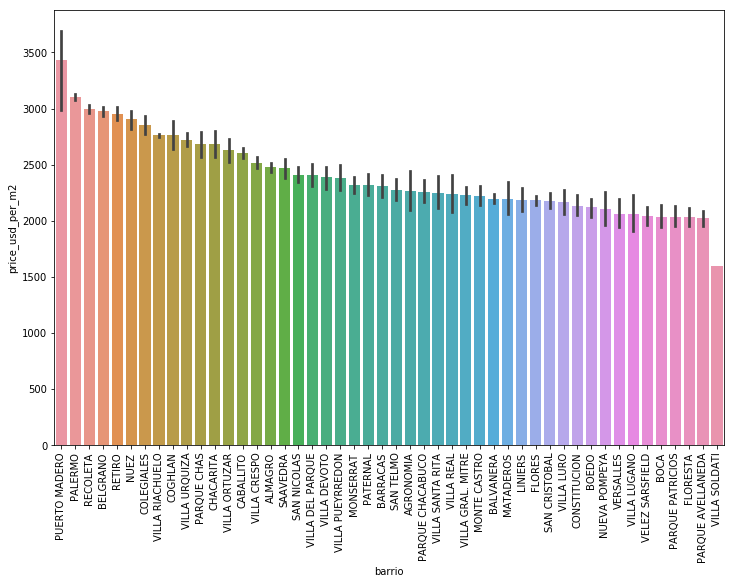

In [27]:
plt.xticks(rotation = 90)
barrios = df_filtered.groupby('barrio').mean().sort_values('price_usd_per_m2', ascending=False).index
sns.barplot(x="barrio", y="price_usd_per_m2", order=barrios, data=df_filtered);

#### Más caros

In [28]:
table = pd.pivot_table(df, values='price_usd_per_m2', index=['barrio'], aggfunc=np.mean)
mas_caros = table.sort_values('price_usd_per_m2', ascending=False).iloc[:5]
mas_caros

,price_usd_per_m2
barrio,
PUERTO MADERO,6156.633183
PALERMO,3632.057960
RETIRO,3417.635657
RECOLETA,3346.748987
BELGRANO,3338.725206


#### Más baratos

In [29]:
table = pd.pivot_table(df, values='price_usd_per_m2', index=['barrio'], aggfunc=np.mean)
mas_baratos = table.sort_values('price_usd_per_m2', ascending=True).iloc[:5]
mas_baratos

,price_usd_per_m2
barrio,
VILLA SOLDATI,920.825753
VILLA LUGANO,1179.846071
VILLA RIACHUELO,1274.809950
PARQUE AVELLANEDA,1386.260577
NUEVA POMPEYA,1539.235869


## Graficando propiedades de los barrios

Ahora que ya sabemos cuales son los barrios más caros y cuales son los más baratos vamos a ver algunas comparaciones gráficas para entender mejor sus diferencias en diferentes atributos del dataset. Vamos a ver las distribuciones según:
- Superficie total en m2
- Cuartos totales 
- Precio en dolares por m2

In [30]:
barrios_caros = mas_caros.index 
barrios_baratos = mas_baratos.index

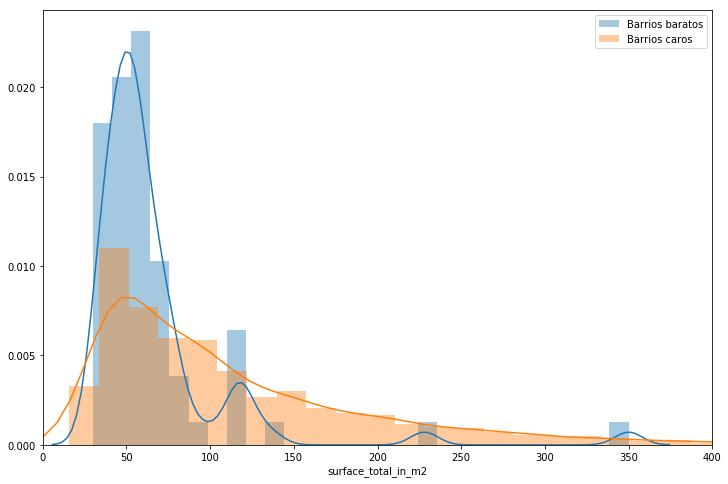

In [31]:
g = sns.distplot(df_filtered[df_filtered.barrio.isin(barrios_baratos)].surface_total_in_m2, label="Barrios baratos")
sns.distplot(df_filtered[df_filtered.barrio.isin(barrios_caros)].surface_total_in_m2, label="Barrios caros")
g.set_xlim(0, 400)
plt.legend()

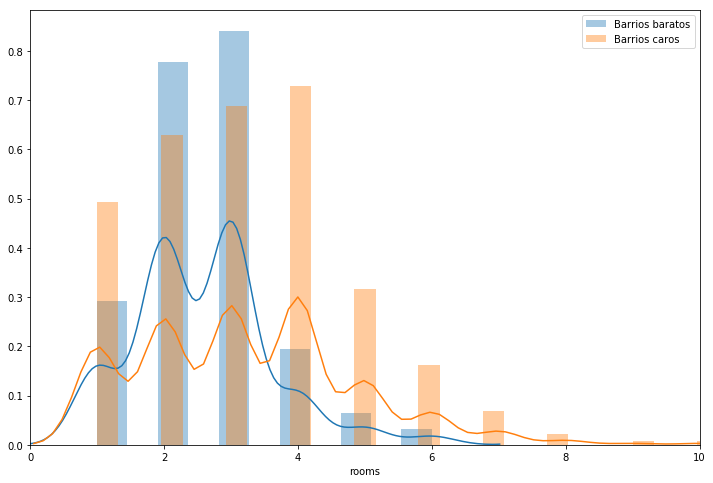

In [32]:
g = sns.distplot(df_filtered[df_filtered.barrio.isin(barrios_baratos)].rooms, label="Barrios baratos")
sns.distplot(df_filtered[df_filtered.barrio.isin(barrios_caros)].rooms, label="Barrios caros")
g.set_xlim(0, 10)
plt.legend()

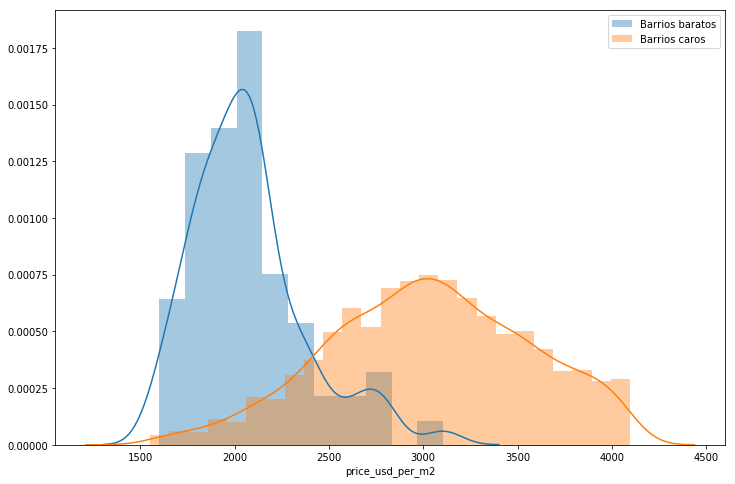

In [33]:
g = sns.distplot(df_filtered[df_filtered.barrio.isin(barrios_baratos)].price_usd_per_m2, label="Barrios baratos")
sns.distplot(df_filtered[df_filtered.barrio.isin(barrios_caros)].price_usd_per_m2, label="Barrios caros")
plt.legend()

### Barrios que quieren ser otros

Basado en información de mercado, desde el portal Properati han señalado que las inmobiliarias suelen publicar las propiedades ubicadas en barrios que no necesariamente se corresponden con la ubicación geográfica real. Según mencionan en la [nota](http://blog.properati.com.ar/barrios-que-quieren-ser-otros/), ésto corresponde a una lógica comercial en el corredor norte y a usos y costumbres en zona oeste.

Analicemos qué sucede para nuestro dataset.

Dada la estructura del atributo `place_with_parent_names`, en primer lugar voy a extraer el campo asociado al barrio publicado para poder comparar con el que surge de la cartografía oficial. Ésto lo voy a agregar en una nueva columna llamada `barrio_publicado`. 

De éste modo, lo que voy a analizar es cómo se relacionan las columnas `barrio` y `barrio publicado`. Si efectivamente hay barrios que quieren ser otros, esperaríamos ver propiedades ubicadas geográficamente en un barrio distinto al que dice la publicación. Por ejemplo, si una propiedad está ubicada (dadas sus coordenadas) en Villa Crespo pero en la publicación dice Palermo, entonces decimos que hay indicios que Villa Crespo quiere ser Palermo.

Viendo la estructura de éste atributo, podemos notar que se compone por una secuencia de lugares separados por `|`. Por ejemplo, en `|Argentina|Capital Federal|Palermo|` vemos que primero está el país, luego la ciudad, luego el barrio y en algunos casos hay una jerarquía más, relacionado con zonas dentro del barrio (como Palermo Soho dentro de Palermo). 

De éste modo, una estrategia posible para resolver ésto es separar las jerarquías por `|` y extraer el elemento asociado al barrio. Por ejemplo, para `|Argentina|Capital Federal|Palermo|` queda `['', 'Argentina', 'Capital Federal', 'Palermo', '']`. Extrayendo el tercer elemento obtendremos el barrio independientemente de si hay lugares luego en la jerarquía. Aquellos que no tengan barrio no serán considerados puesto que estarían ubicados en Capital Federal y no sería informativo.

Lo paso a mayúsculas y quito las tildes para poder comparar con el barrio oficial.

In [34]:
df_filtered['place_with_parent_names'].apply(lambda x: len(x.split("|"))).unique()

array([5, 6, 4])

Como algunos tienen 4 elementos, debemos quitarlos.

In [35]:
split_place_filter = df_filtered['place_with_parent_names'].apply(lambda x: len(x.split("|"))!=4)
df_filtered = df_filtered.loc[split_place_filter]

In [36]:
df_filtered['barrio_publicado'] = df_filtered['place_with_parent_names'].apply( lambda x: x.split("|")[3].upper())
df_filtered['barrio_publicado'] = df_filtered['barrio_publicado'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

Comparemos entonces el barrio publicado con el real. Nos vamos a quedar con aquellas propiedades donde nos coincidan para luego hacer el conteo por barrio.

In [37]:
barrios_match = (df_filtered['barrio_publicado'] != df_filtered['barrio'])
df_filtered_barrio_not_match = df_filtered.loc[barrios_match]

Con una tabla de doble entrada podemos identificar para cada barrio cuál es al que más quiere parecerse.

In [38]:
table = pd.crosstab(df_filtered_barrio_not_match.barrio, df_filtered_barrio_not_match.barrio_publicado)
table.idxmax(axis=1)

barrio
AGRONOMIA                VILLA PUEYRREDON
ALMAGRO                         CABALLITO
BALVANERA                            ONCE
BARRACAS                        SAN TELMO
BELGRANO                            NUNEZ
BOCA                             BARRACAS
BOEDO                             ALMAGRO
CABALLITO               PARQUE CENTENARIO
CHACARITA                      COLEGIALES
COGHLAN                          BELGRANO
COLEGIALES                       BELGRANO
CONSTITUCION                    SAN TELMO
FLORES                          CABALLITO
FLORESTA                           FLORES
LINIERS                         VERSALLES
MATADEROS                         LINIERS
MONSERRAT                       SAN TELMO
MONTE CASTRO                 VILLA DEVOTO
NUEVA POMPEYA            PARQUE PATRICIOS
NUEZ                                NUNEZ
PALERMO                          BELGRANO
PARQUE AVELLANEDA                FLORESTA
PARQUE CHACABUCO                CABALLITO
PARQUE CHAS                

Podemos ver entonces que los barrios tienden a querer parecerse a barrios con precio con metro cuadrado más caro. Por ejemplo Villa Crespo con Palermo, Constitución con San Telmo y Villa Urquiza con Belgrano. 

Por otro lado, vemos también que los barrios suelen querer parecerse a sus barrios vecinos.